In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Step 1: Load Asset Data
def load_data(tickers, start_date, end_date):
    """
    Fetches adjusted closing prices for given tickers from Yahoo Finance.
    """
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    data = data.dropna()
    return data

# Step 2: Calculate Expected Returns and Covariance Matrix
def calculate_returns(data):
    """
    Calculates daily returns, expected annual returns, and annual covariance matrix.
    """
    daily_returns = data.pct_change().dropna()
    mean_daily_returns = daily_returns.mean()
    cov_matrix = daily_returns.cov()
    # Annualize the returns and covariance
    annual_returns = mean_daily_returns * 252
    annual_cov_matrix = cov_matrix * 252
    return annual_returns, annual_cov_matrix

# Step 3: Portfolio Performance Metrics
def portfolio_performance(weights, returns, cov_matrix):
    """
    Calculates portfolio return and volatility.
    """
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# Step 4: Optimization Functions
def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.0):
    """
    Returns the negative Sharpe ratio of the portfolio.
    """
    p_return, p_volatility = portfolio_performance(weights, returns, cov_matrix)
    if p_volatility == 0:
        return np.inf  # Avoid division by zero
    return -(p_return - risk_free_rate) / p_volatility

def portfolio_variance(weights, cov_matrix):
    """
    Returns the portfolio variance.
    """
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def optimize_portfolio(returns, cov_matrix, risk_free_rate=0.0):
    """
    Optimizes the portfolio to maximize the Sharpe ratio.
    """
    num_assets = len(returns)
    args = (returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = num_assets * [1. / num_assets,]
    result = minimize(negative_sharpe_ratio, initial_guess, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Step 5: Efficient Frontier
def efficient_frontier(returns, cov_matrix, num_portfolios=100):
    """
    Computes the efficient frontier.
    """
    results = np.zeros((3, num_portfolios))
    weights_record = []
    target_returns = np.linspace(returns.min(), returns.max(), num_portfolios)
    for i, target_return in enumerate(target_returns):
        constraints = (
            {'type': 'eq', 'fun': lambda x: portfolio_performance(x, returns, cov_matrix)[0] - target_return},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        )
        bounds = tuple((0, 1) for _ in range(len(returns)))
        initial_guess = len(returns) * [1. / len(returns),]
        result = minimize(portfolio_variance, initial_guess, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            p_var = portfolio_variance(result.x, cov_matrix)
            p_ret = portfolio_performance(result.x, returns, cov_matrix)[0]
            results[0,i] = p_ret
            results[1,i] = np.sqrt(p_var)
            results[2,i] = (p_ret - 0.0) / np.sqrt(p_var)  # Sharpe Ratio
            weights_record.append(result.x)
        else:
            # If optimization fails, assign NaN
            results[0,i] = np.nan
            results[1,i] = np.nan
            results[2,i] = np.nan
            weights_record.append(None)
    # Remove portfolios where optimization failed
    valid_indices = ~np.isnan(results[0,:])
    return results[:, valid_indices], [w for w in weights_record if w is not None]

In [8]:
def calculate_portfolio(tickers, start_date, end_date):
    # Define asset tickers and time period
    

    # Load data
    try:
        data = load_data(tickers, start_date, end_date)
        print("Data loaded successfully.")
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # Check if data is sufficient
    if data.empty:
        print("No data fetched. Please check the tickers and date range.")
        return

    # Calculate returns and covariance
    returns, cov_matrix = calculate_returns(data)
    print("Returns and covariance matrix calculated.")

    # Optimize portfolio for maximum Sharpe ratio
    optimal = optimize_portfolio(returns, cov_matrix)
    if optimal.success:
        print("Optimal portfolio found.")
        print("Weights:", optimal.x)
        opt_return, opt_volatility = portfolio_performance(optimal.x, returns, cov_matrix)
        print(f"Expected Annual Return: {opt_return:.2f}")
        print(f"Annual Volatility: {opt_volatility:.2f}")
        print(f"Sharpe Ratio: {(opt_return)/opt_volatility:.2f}")
    else:
        print("Optimization failed.")
        print("Message:", optimal.message)
        opt_return, opt_volatility = None, None  # Assign None to handle later

    # Compute efficient frontier
    frontier, weights = efficient_frontier(returns, cov_matrix)
    print("Efficient frontier computed.")

    # Plotting
    plt.figure(figsize=(10, 7))
    # Scatter plot for efficient frontier
    scatter = plt.scatter(frontier[1,:], frontier[0,:], c=frontier[2,:], cmap='viridis', marker='o', s=10, alpha=0.3)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Sharpe Ratio')

    # Plot optimal portfolio if optimization was successful
    if opt_return is not None and opt_volatility is not None:
        plt.scatter(opt_volatility, opt_return, marker='*', color='r', s=500, label='Optimal Portfolio')

    plt.title('Efficient Frontier')
    plt.xlabel('Annual Volatility')
    plt.ylabel('Annual Return')
    plt.legend(labelspacing=0.8)
    plt.grid(True)
    plt.show()


[*********************100%***********************]  85 of 85 completed


Data loaded successfully.
Returns and covariance matrix calculated.
Optimal portfolio found.
Weights: [5.44037298e-15 0.00000000e+00 2.68754362e-15 9.89858070e-15
 7.52558247e-15 0.00000000e+00 1.55500938e-14 0.00000000e+00
 0.00000000e+00 1.09080094e-01 0.00000000e+00 2.33867050e-17
 0.00000000e+00 0.00000000e+00 8.57628172e-02 3.51149225e-02
 2.51807974e-14 2.90293846e-14 1.99205509e-14 2.93257893e-01
 0.00000000e+00 1.13351196e-14 8.28831298e-15 1.23675969e-14
 2.72191666e-14 2.59551801e-15 0.00000000e+00 2.29750909e-14
 4.02541406e-15 1.66638398e-14 0.00000000e+00 1.25504795e-14
 2.56613248e-14 1.52149288e-14 0.00000000e+00 0.00000000e+00
 3.00088595e-14 1.11021681e-14 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.26821550e-15 0.00000000e+00
 1.98065176e-14 3.89649095e-15 0.00000000e+00 1.22312430e-15
 2.19524787e-14 0.00000000e+00 2.38467543e-14 0.00000000e+00
 5.18016221e-15 2.52692654e-14 0.00000000e+00 1.32329195e-14
 0.00000000e+00 0.00000000e+00 0.00000000e+0

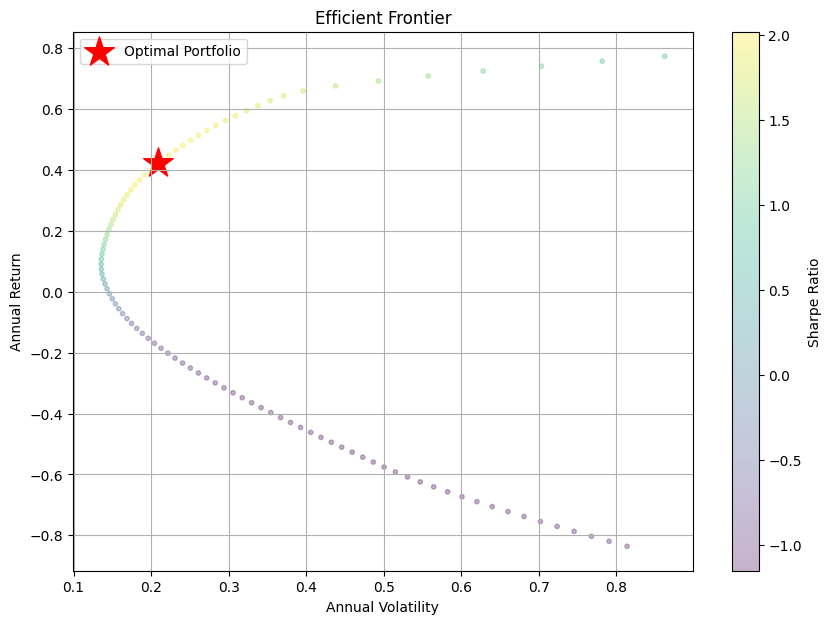

In [10]:
nasdaq =["AAPL", "ABNB", "ADBE", "ADI", "ADP", "ADSK", "AEP", "AMAT", "AMD", "AMGN", 
"AMZN", "ANSS", "APP", "ASML", "AVGO", "AXON", "AZN", "BKR", "CDNS", 
"CEG", "CHTR", "CMCSA", "CSGP", "CSX", "CTAS", "CTSH", "DDOG", "DLTR", "DXCM", 
"EA", "EBAY", "EXC", "FAST", "FANG", "FTNT", "GFS", "GILD", "HON", "IDXX", 
"ILMN", "INTC", "INTU", "ISRG", "JD", "KDP", "KLAC", "LCID", "LRCX", "MAR", 
"MCHP", "MDLZ", "MELI", "META", "MNST", "MRVL", "MSFT", "MU", "NFLX", "NTES", 
"NVDA", "NXPI", "ORLY", "PANW", "PCAR", "PDD", "PEP", "PYPL", "QCOM", "REGN", 
"ROST", "SBUX", "SNPS", "SWKS", "TEAM", "TMUS", "TSLA", "TTD", "TTWO", 
"TXN", "VRSK", "VRTX", "WBD", "WDAY", "XEL", "ZS"]

calculate_portfolio(nasdaq, "2020-01-01", "2023-12-31")